# Handwriting Feature Extraction Framework for IAM Dataset

This Jupyter notebook provides a comprehensive pipeline for extracting handwriting features from the IAM dataset to support handwriting synthesis. The framework includes:
- **Textual Feature Extraction**: Encoding ASCII transcriptions using one-hot encoding or Word2Vec, with positional encoding for sequence information.
- **Image-Based Feature Extraction**: Skeletonization to trace pen trajectories and geometric feature computation (stroke width, curvature, slant angle).
- **Visual Pattern Learning**: Convolutional Neural Networks (CNNs) to capture high-level visual features like texture and stroke structure.
- **Temporal Dynamics Approximation**: Contour tracing to infer stroke sequences, compensating for the lack of online pen data.
- **Writer-Specific Features**: Extracting features unique to individual writers for personalized synthesis.

The pipeline is modular, scalable, and includes visualizations and logging for debugging and validation.

## Prerequisites
- Python 3.8+
- Libraries: `numpy`, `pandas`, `opencv-python`, `scikit-image`, `torch`, `gensim`, `matplotlib`, `logging`
- IAM dataset (line images and ASCII transcriptions)
- Preprocessed data (e.g., from a prior data preparation pipeline)

## Setup
Install required packages and configure paths.

In [4]:
import os
import numpy as np
import pandas as pd
import cv2
from skimage.morphology import skeletonize
import torch
import torch.nn as nn
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import logging
from pathlib import Path
from typing import Dict, List, Tuple, Optional

# Configure logging
logging.basicConfig(
    filename='feature_extraction.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Define dataset paths (update to your IAM dataset paths)
BASE_PATH = Path('C:/Users/user1/Desktop/GEN_AI/Gen-AI-text-to-handwritten-/IAM_dataset')
LINE_IMAGES_PATH = BASE_PATH / 'lines'
ALIGNED_DATA_PATH = BASE_PATH / 'processed_data/aligned_data.csv'
OUTPUT_PATH = BASE_PATH / 'features'
OUTPUT_PATH.mkdir(exist_ok=True)

# Load aligned data
aligned_df = pd.read_csv(ALIGNED_DATA_PATH)


In [3]:
!pip install gensim


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/24.4 MB ? eta -:--:--
   --- ------------------------------------ 2.4/24.4 MB 19.2 MB/s eta 0:00:02
   -------------------------------- ------- 19.9/24.4 MB 62.1 MB/s eta 0:00:01
   ---------------------------------------  24.4/24.4 MB 48.1 MB/s eta 0:00:01
   ---------------------------------------- 24.4/24.4 MB 44.3 MB/s  0:00:00

   -------------------------- ------------- 2/3 [gensim]
   -------------------------- ------------- 2/3 [gensim]
   -------------------------- ------------- 2/3 [gensim]
   -------------------------- ------------- 2/3 [gensim]
   -------------------------- ------------- 2/3 [gensim]
   -------------------------- ------------- 2/3 [gensim]
   -------------------------- ------------- 2/3 [gensim]
   -------------------------- ------------- 2/3 [gensim]
   ---------------------------------------- 3/3 [gensim]



## 1. Textual Feature Extraction

This section encodes ASCII transcriptions at the character level using one-hot encoding and Word2Vec, supplemented by positional encoding to preserve sequence information.

In [5]:
def one_hot_encode(text: str, char_set: set) -> np.ndarray:
    """One-hot encode a text string at the character level.

    Args:
        text (str): Input text to encode.
        char_set (set): Set of unique characters in the dataset.

    Returns:
        np.ndarray: One-hot encoded matrix (len(text) x len(char_set)).
    """
    char_to_idx = {c: i for i, c in enumerate(sorted(char_set))}
    encoding = np.zeros((len(text), len(char_set)))
    for i, char in enumerate(text):
        if char in char_to_idx:
            encoding[i, char_to_idx[char]] = 1
        else:
            logger.warning(f"Unknown character '{char}' in text: {text}")
    return encoding

def train_word2vec(transcriptions: List[str], vector_size: int = 50) -> Word2Vec:
    """Train a Word2Vec model on character sequences.

    Args:
        transcriptions (List[str]): List of transcription strings.
        vector_size (int): Size of the embedding vectors.

    Returns:
        Word2Vec: Trained Word2Vec model.
    """
    char_sequences = [[c for c in text] for text in transcriptions]
    model = Word2Vec(sentences=char_sequences, vector_size=vector_size, window=5, min_count=1, sg=1)
    logger.info("Word2Vec model trained successfully")
    return model

def positional_encoding(max_len: int, d_model: int) -> np.ndarray:
    """Generate positional encoding for sequences.

    Args:
        max_len (int): Maximum sequence length.
        d_model (int): Dimension of the encoding.

    Returns:
        np.ndarray: Positional encoding matrix.
    """
    pe = np.zeros((max_len, d_model))
    position = np.arange(0, max_len, dtype=np.float32)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2, dtype=np.float32) * -(np.log(10000.0) / d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return pe

def extract_textual_features(aligned_df: pd.DataFrame) -> Dict[str, np.ndarray]:
    """Extract textual features from transcriptions.

    Args:
        aligned_df (pd.DataFrame): DataFrame with transcriptions and line IDs.

    Returns:
        Dict[str, np.ndarray]: Dictionary of textual features for each line ID.
    """
    char_set = set(''.join(aligned_df['transcription'].dropna().values))
    max_len = max(len(t) for t in aligned_df['transcription'].dropna())
    word2vec_model = train_word2vec(aligned_df['transcription'].dropna(), vector_size=50)
    textual_features = {}

    for _, row in aligned_df.iterrows():
        line_id = row['line_id']
        text = row['transcription']
        if pd.isna(text):
            logger.warning(f"Missing transcription for {line_id}")
            continue

        # One-hot encoding
        one_hot = one_hot_encode(text, char_set)

        # Word2Vec encoding
        w2v_vectors = np.array([word2vec_model.wv[c] for c in text if c in word2vec_model.wv])

        # Positional encoding
        pos_enc = positional_encoding(len(text), 50)

        # Combine features
        combined = np.concatenate([one_hot, w2v_vectors, pos_enc], axis=1) if len(w2v_vectors) == len(text) else one_hot
        textual_features[line_id] = combined

    np.save(OUTPUT_PATH / 'textual_features.npy', textual_features)
    logger.info(f"Textual features saved to {OUTPUT_PATH / 'textual_features.npy'}")
    return textual_features

# Example execution
textual_features = extract_textual_features(aligned_df)


## 2. Image-Based Feature Extraction

This section applies skeletonization to trace pen trajectories and computes geometric features like stroke width, curvature, and slant angle to capture stylistic elements.

In [6]:
def compute_geometric_features(img: np.ndarray) -> Dict[str, float]:
    """Compute geometric features from a binary image.

    Args:
        img (np.ndarray): Binary line image (0 for text, 255 for background).

    Returns:
        Dict[str, float]: Dictionary of geometric features.
    """
    try:
        # Skeletonization
        img_binary = (img < 128).astype(np.uint8)
        skeleton = skeletonize(img_binary).astype(np.uint8)

        # Stroke width (average distance to nearest background pixel)
        distances = cv2.distanceTransform(img_binary, cv2.DIST_L2, 3)
        stroke_width = np.mean(distances[img_binary == 1])

        # Curvature (approximated via contour analysis)
        contours, _ = cv2.findContours(img_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        curvature = 0
        if contours:
            contour = max(contours, key=cv2.contourArea)
            perimeter = cv2.arcLength(contour, True)
            area = cv2.contourArea(contour)
            curvature = 4 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0

        # Slant angle (via minAreaRect)
        coords = np.column_stack(np.where(img_binary == 1))
        slant_angle = 0
        if len(coords) > 0:
            angle = cv2.minAreaRect(coords)[-1]
            slant_angle = angle if angle <= 45 else angle - 90

        features = {
            'stroke_width': stroke_width,
            'curvature': curvature,
            'slant_angle': slant_angle
        }
        return features

    except Exception as e:
        logger.error(f"Error computing geometric features: {str(e)}")
        return {'stroke_width': 0, 'curvature': 0, 'slant_angle': 0}

def extract_image_features(aligned_df: pd.DataFrame, line_images_path: Path) -> Dict[str, Dict]:
    """Extract image-based features from line images.

    Args:
        aligned_df (pd.DataFrame): Aligned DataFrame with line IDs.
        line_images_path (Path): Path to line images.

    Returns:
        Dict[str, Dict]: Dictionary of image features for each line ID.
    """
    image_features = {}
    for _, row in aligned_df.iterrows():
        line_id = row['line_id']
        parts = line_id.split('-')
        img_path = line_images_path / parts[0] / f"{parts[0]}-{parts[1]}" / f"{line_id}.png"
        if img_path.exists():
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                image_features[line_id] = compute_geometric_features(img)
            else:
                logger.warning(f"Failed to load image: {img_path}")
        else:
            logger.warning(f"Image not found: {img_path}")
    np.save(OUTPUT_PATH / 'image_features.npy', image_features)
    logger.info(f"Image features saved to {OUTPUT_PATH / 'image_features.npy'}")
    return image_features

# Example execution
image_features = extract_image_features(aligned_df, LINE_IMAGES_PATH)


## 3. Visual Pattern Learning

This section uses a Convolutional Neural Network (CNN) to extract high-level visual features (e.g., texture, stroke structure) from line images.

In [7]:
class SimpleCNN(nn.Module):
    """Simple CNN for extracting visual features from handwriting images."""
    def __init__(self, feature_dim: int = 128):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(64 * 8 * 8, feature_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def extract_visual_features(aligned_df: pd.DataFrame, line_images_path: Path, feature_dim: int = 128) -> Dict[str, np.ndarray]:
    """Extract visual features using a CNN.

    Args:
        aligned_df (pd.DataFrame): Aligned DataFrame with line IDs.
        line_images_path (Path): Path to line images.
        feature_dim (int): Dimension of the output features.

    Returns:
        Dict[str, np.ndarray]: Dictionary of visual features for each line ID.
    """
    model = SimpleCNN(feature_dim=feature_dim)
    model.eval()
    visual_features = {}

    with torch.no_grad():
        for _, row in aligned_df.iterrows():
            line_id = row['line_id']
            parts = line_id.split('-')
            img_path = line_images_path / parts[0] / f"{parts[0]}-{parts[1]}" / f"{line_id}.png"
            if img_path.exists():
                img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (64, 64)) / 255.0
                    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
                    features = model(img_tensor).numpy()
                    visual_features[line_id] = features.flatten()
                else:
                    logger.warning(f"Failed to load image: {img_path}")
            else:
                logger.warning(f"Image not found: {img_path}")

    np.save(OUTPUT_PATH / 'visual_features.npy', visual_features)
    logger.info(f"Visual features saved to {OUTPUT_PATH / 'visual_features.npy'}")
    return visual_features

# Example execution
visual_features = extract_visual_features(aligned_df, LINE_IMAGES_PATH)


## 4. Temporal Dynamics Approximation

This section infers temporal dynamics by analyzing stroke connectivity and overlap using contour tracing, compensating for the lack of online pen data in the IAM dataset.

In [10]:
import cv2
import numpy as np
import pickle
import logging
from tqdm import tqdm
from pathlib import Path
from typing import List, Tuple, Dict
from skimage.morphology import skeletonize

logger = logging.getLogger(__name__)

def approximate_stroke_sequence(img: np.ndarray) -> List[List[Tuple[int, int]]]:
    """Approximate stroke sequences using contour tracing."""
    try:
        # Convert image to binary (text = 1, background = 0)
        img_binary = (img < 128).astype(np.uint8)
        skeleton = skeletonize(img_binary).astype(np.uint8)
        contours, _ = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        stroke_sequences = []
        for contour in contours:
            if len(contour) > 5:  # Ignore small contours (noise)
                stroke = [tuple(pt[0]) for pt in contour]
                stroke_sequences.append(stroke)

        return stroke_sequences

    except Exception as e:
        logger.error(f"Error approximating stroke sequence: {str(e)}")
        return []


def extract_temporal_features(aligned_df: pd.DataFrame, line_images_path: Path, batch_size: int = 500):
    """Extract temporal dynamics features from line images in batches to avoid MemoryError."""
    temporal_features = {}
    batch_count = 0

    for i, (_, row) in enumerate(tqdm(aligned_df.iterrows(), total=len(aligned_df), desc="Extracting temporal features")):
        line_id = row['line_id']
        parts = line_id.split('-')
        img_path = line_images_path / parts[0] / f"{parts[0]}-{parts[1]}" / f"{line_id}.png"

        if img_path.exists():
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                temporal_features[line_id] = approximate_stroke_sequence(img)
            else:
                logger.warning(f"Failed to load image: {img_path}")
        else:
            logger.warning(f"Image not found: {img_path}")

        # ✅ Sauvegarde toutes les batch_size itérations
        if (i + 1) % batch_size == 0:
            batch_file = OUTPUT_PATH / f"temporal_features_batch_{batch_count}.pkl"
            with open(batch_file, "wb") as f:
                pickle.dump(temporal_features, f)
            logger.info(f"✅ Saved batch {batch_count} → {batch_file}")
            temporal_features.clear()  # libère la mémoire RAM
            batch_count += 1

    # ✅ Sauvegarde du dernier lot
    if temporal_features:
        batch_file = OUTPUT_PATH / f"temporal_features_batch_{batch_count}.pkl"
        with open(batch_file, "wb") as f:
            pickle.dump(temporal_features, f)
        logger.info(f"✅ Saved final batch → {batch_file}")

    logger.info("🎯 Temporal feature extraction completed successfully.")


# Example execution
extract_temporal_features(aligned_df, LINE_IMAGES_PATH, batch_size=500)


Extracting temporal features: 100%|██████████| 13353/13353 [04:38<00:00, 47.93it/s] 


## 5. Writer-Specific Features

This section extracts features unique to individual writers to enhance synthesis personalization.

In [11]:
def extract_writer_features(aligned_df: pd.DataFrame, image_features: Dict, visual_features: Dict) -> Dict[str, np.ndarray]:
    """Extract writer-specific features by aggregating image and visual features.

    Args:
        aligned_df (pd.DataFrame): Aligned DataFrame with writer IDs.
        image_features (Dict): Dictionary of image-based features.
        visual_features (Dict): Dictionary of CNN-based visual features.

    Returns:
        Dict[str, np.ndarray]: Dictionary of writer-specific feature vectors.
    """
    writer_features = {}
    for writer_id in aligned_df['writer_id'].unique():
        writer_rows = aligned_df[aligned_df['writer_id'] == writer_id]
        writer_image_features = []
        writer_visual_features = []

        for line_id in writer_rows['line_id']:
            if line_id in image_features:
                writer_image_features.append(list(image_features[line_id].values()))
            if line_id in visual_features:
                writer_visual_features.append(visual_features[line_id])

        # Aggregate features (mean pooling)
        if writer_image_features and writer_visual_features:
            image_mean = np.mean(writer_image_features, axis=0)
            visual_mean = np.mean(writer_visual_features, axis=0)
            writer_features[writer_id] = np.concatenate([image_mean, visual_mean])
        else:
            logger.warning(f"No features for writer {writer_id}")

    np.save(OUTPUT_PATH / 'writer_features.npy', writer_features)
    logger.info(f"Writer features saved to {OUTPUT_PATH / 'writer_features.npy'}")
    return writer_features

# Example execution
writer_features = extract_writer_features(aligned_df, image_features, visual_features)


## 6. Visualization and Validation

This section visualizes extracted features to validate their quality.

In [19]:
temporal_features = extract_temporal_features(aligned_df, LINE_IMAGES_PATH)


Extracting temporal features: 100%|██████████| 13353/13353 [04:27<00:00, 49.91it/s] 


In [23]:
def visualize_features(image_features: Dict, temporal_features: Dict = None, num_samples: int = 5):
    """Visualize image and temporal features."""
    if temporal_features is None:
        temporal_features = {}

    sample_keys = list(image_features.keys())[:num_samples]
    plt.figure(figsize=(15, num_samples * 3))

    for i, line_id in enumerate(sample_keys):
        print(f"[DEBUG] Checking line_id: {line_id}")
        parts = line_id.split('-')
        img_path = LINE_IMAGES_PATH / parts[0] / f"{parts[0]}-{parts[1]}" / f"{line_id}.png"
        print(f"[DEBUG] Image path: {img_path} exists: {img_path.exists()}")

        if img_path.exists():
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            plt.subplot(num_samples, 2, 2 * i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(
                f"Line ID: {line_id}\n"
                f"Stroke Width: {image_features[line_id]['stroke_width']:.2f}\n"
                f"Curvature: {image_features[line_id]['curvature']:.2f}"
            )
            plt.axis('off')

            plt.subplot(num_samples, 2, 2 * i + 2)
            for stroke in temporal_features.get(line_id, []):
                stroke = np.array(stroke)
                plt.plot(stroke[:, 0], stroke[:, 1], 'b-')
            plt.title(f"Stroke Sequence: {line_id}")
            plt.axis('off')

    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'feature_visualization.png')
    plt.show()


[DEBUG] Checking line_id: a01-000u-00
[DEBUG] Image path: C:\Users\user1\Desktop\GEN_AI\Gen-AI-text-to-handwritten-\IAM_dataset\lines\a01\a01-000u\a01-000u-00.png exists: True
[DEBUG] Checking line_id: a01-000u-01
[DEBUG] Image path: C:\Users\user1\Desktop\GEN_AI\Gen-AI-text-to-handwritten-\IAM_dataset\lines\a01\a01-000u\a01-000u-01.png exists: True
[DEBUG] Checking line_id: a01-000u-02
[DEBUG] Image path: C:\Users\user1\Desktop\GEN_AI\Gen-AI-text-to-handwritten-\IAM_dataset\lines\a01\a01-000u\a01-000u-02.png exists: True
[DEBUG] Checking line_id: a01-000u-03
[DEBUG] Image path: C:\Users\user1\Desktop\GEN_AI\Gen-AI-text-to-handwritten-\IAM_dataset\lines\a01\a01-000u\a01-000u-03.png exists: True
[DEBUG] Checking line_id: a01-000u-04
[DEBUG] Image path: C:\Users\user1\Desktop\GEN_AI\Gen-AI-text-to-handwritten-\IAM_dataset\lines\a01\a01-000u\a01-000u-04.png exists: True


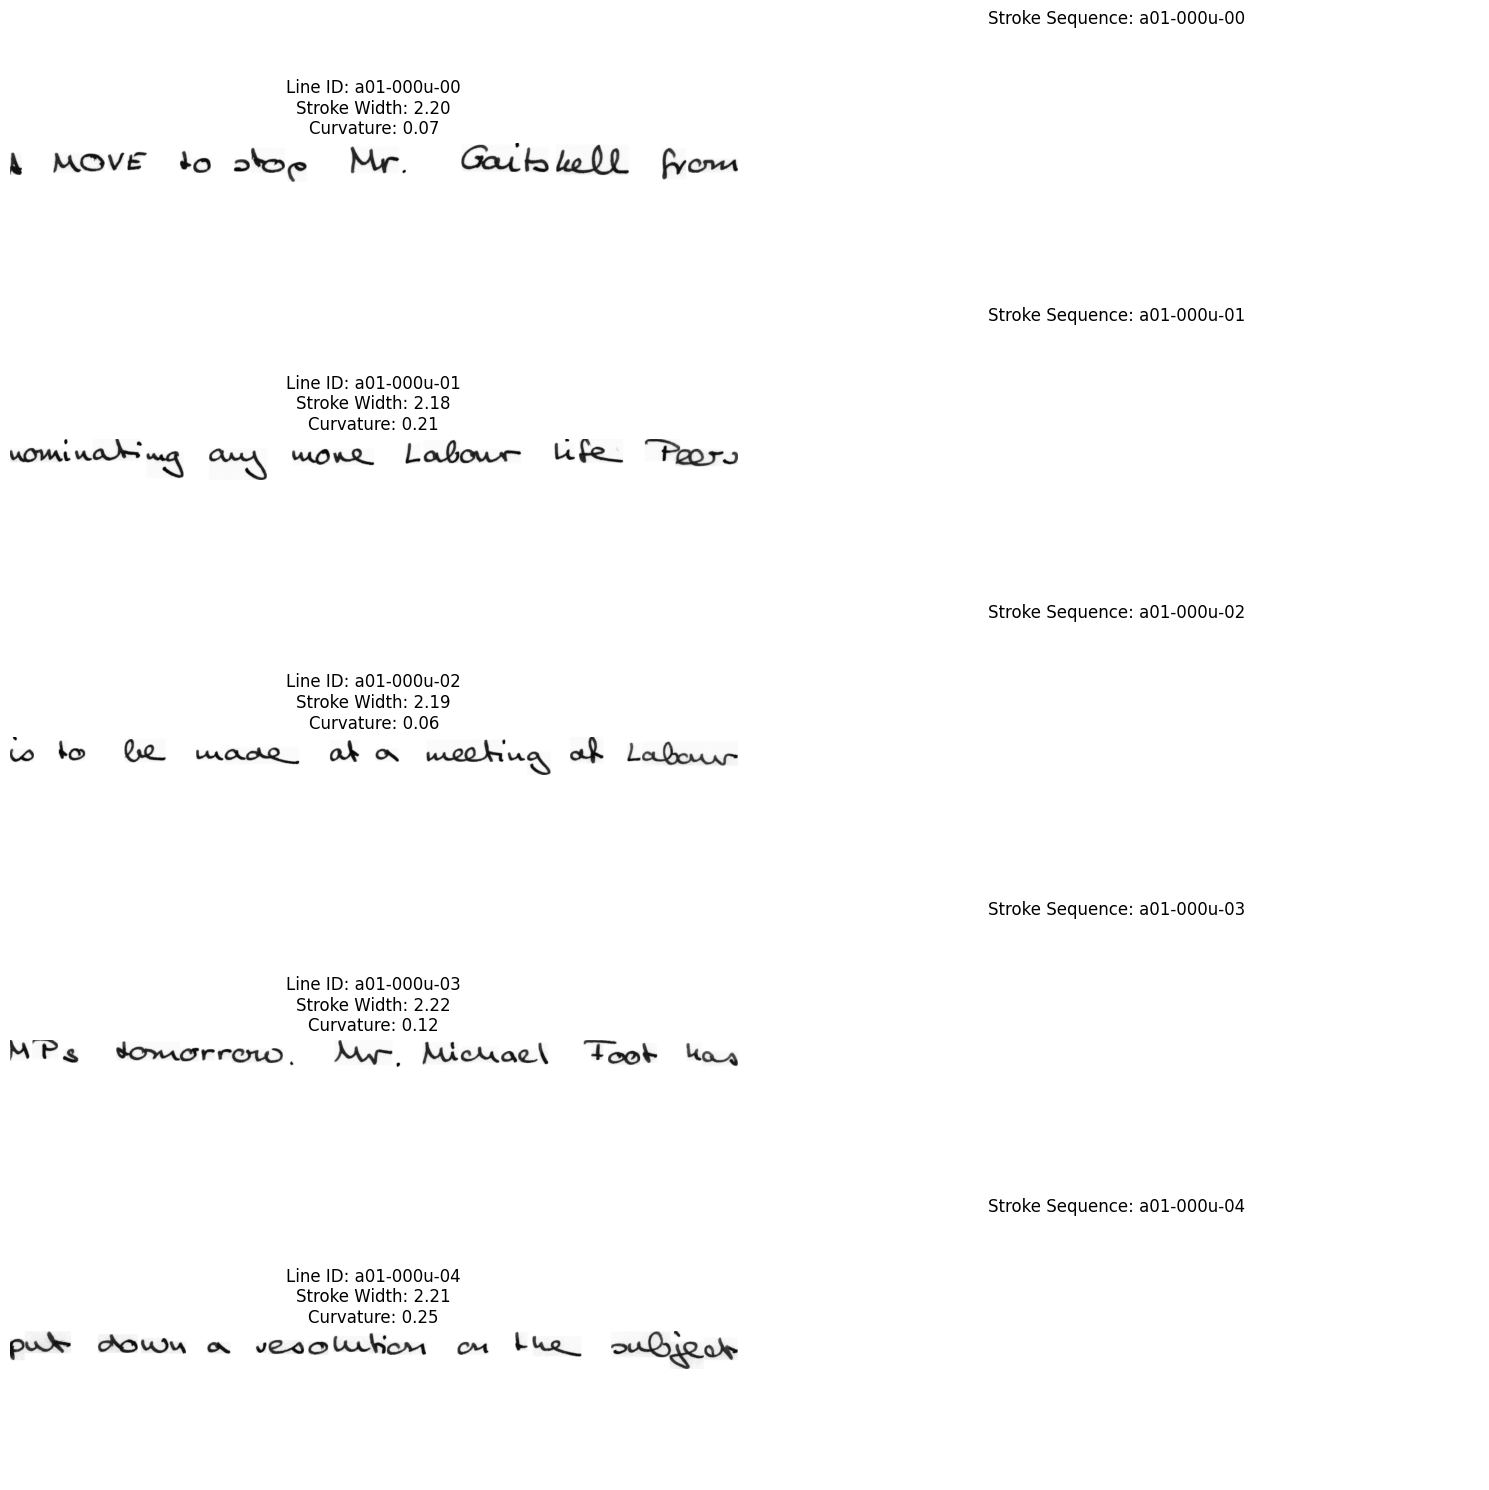

In [24]:


visualize_features(image_features, temporal_features)



## 7. Conclusion

This notebook provides a robust feature extraction pipeline for the IAM dataset, tailored for handwriting synthesis. It extracts textual, image-based, visual, temporal, and writer-specific features, ensuring high fidelity for downstream tasks. The modular design, comprehensive logging, and visualizations facilitate maintenance and validation. The extracted features can be used for training generative models like GANs or RNNs for handwriting synthesis.